# Train a classifier for Stanford Car Dataset


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset,DataLoader, Subset
import torchvision
from torchvision import models, utils, transforms
from torchsummary import summary

import time
import os
import random
import copy
import pickle
from PIL import Image
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

dataset_dir = "./stanford_car"
model_dir = './models/'
img_dir = './imgs/'
para_dir = './params/'

cuda:0
GeForce GTX 1060 with Max-Q Design


## Load the data and do some transformations

In [2]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def show(img, label, color=True):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    if color == False:
        img = img[:,:,0]
        plt.imshow(img, cmap = "gray", interpolation="nearest")
    else:
         plt.imshow(img, interpolation="nearest")
    plt.title(label)
    
class MapDataset(Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        return self.map(self.dataset[index][0]), self.dataset[index][1]

    def __len__(self):
        return len(self.dataset)

In [3]:
split = [0.9, 0.05, 0.05]
#split = [0.8, 0.1, 0.1]

# load data and label
classes, c_to_idx = find_classes(dataset_dir)
master = torchvision.datasets.ImageFolder(root=dataset_dir)
num_classes = len(classes)

# split data
n = len(master)
n_train = int(split[0]*n)
n_val = int(split[1]*n)
n_test = n - n_train - n_val
idx = list(range(n))
random.seed(37)
torch.manual_seed(37)
random.shuffle(idx)
train_idx = idx[:n_train]
val_idx = idx[n_train:n_train+n_val]
test_idx = idx[n_train+n_val:]

train_ds = Subset(master, train_idx)
val_ds = Subset(master, val_idx)
test_ds = Subset(master, test_idx)
'''
# get mean and std
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)
'''

# define transformations
meanR,meanG,meanB = 0.46999282, 0.45951137, 0.45459473
stdR,stdG,stdB = 0.25914255, 0.25799283, 0.26299596
data_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                               transforms.ToPILImage(),])
train_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15, resample = Image.BILINEAR),
                                 transforms.ToTensor(),
                                 transforms.Normalize((meanR,meanG,meanB), (stdR,stdG,stdB))])
val_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((meanR,meanG,meanB), (stdR,stdG,stdB))])
test_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((meanR,meanG,meanB), (stdR,stdG,stdB))])

# apply transformations
train_ds = MapDataset(train_ds, train_tfms)
val_ds = MapDataset(val_ds, val_tfms)
test_ds = MapDataset(test_ds, test_tfms)

# dataloaders
trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
valloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)
testloader = DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers = 2)

## Dataset visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


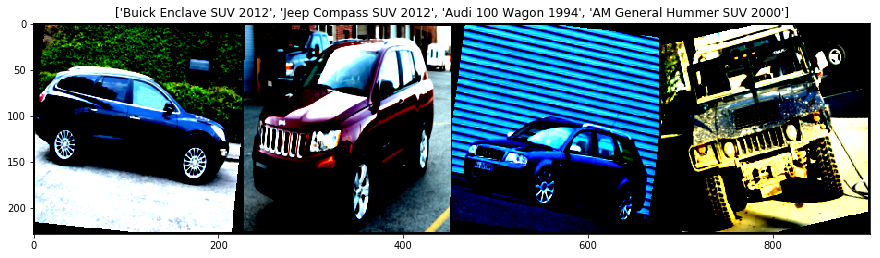

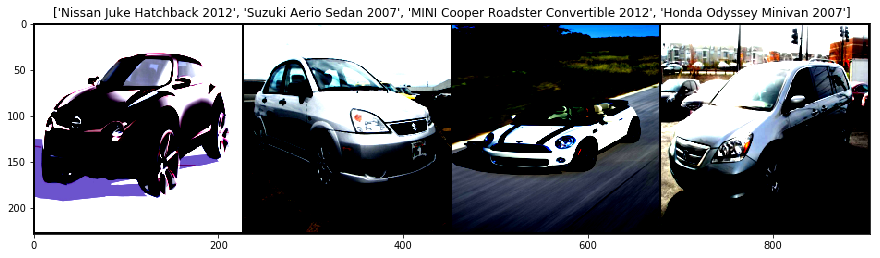

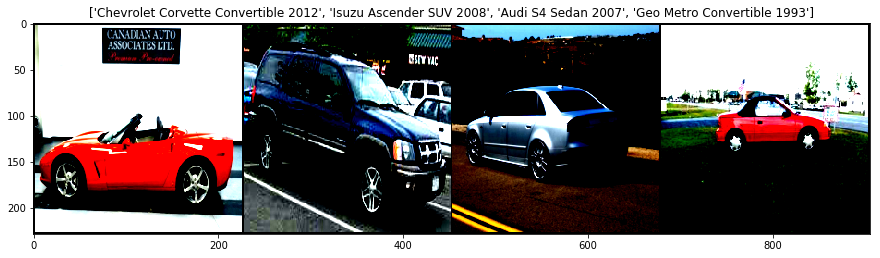

In [4]:
# visualization
for x, y in trainloader:
    x_grid=utils.make_grid(x[0:4,:,:,:], nrow=4, padding=2)
    y_grid = [classes[y[i]] for i in range(4)]
    fig = plt.figure(figsize=(15,15))
    show(x_grid,y_grid,True)
    fig.savefig('train_img.png', bbox_inches='tight')
    break
for x, y in valloader:
    x_grid=utils.make_grid(x[0:4,:,:,:], nrow=4, padding=2)
    y_grid = [classes[y[i]] for i in range(4)]
    fig = plt.figure(figsize=(15,15))
    show(x_grid,y_grid,True)
    fig.savefig('val_img.png', bbox_inches='tight')
    break
for x, y in testloader:
    x_grid=utils.make_grid(x[0:4,:,:,:], nrow=4, padding=2)
    y_grid = [classes[y[i]] for i in range(4)]
    fig = plt.figure(figsize=(15,15))
    show(x_grid,y_grid,True)
    fig.savefig('test_img.png', bbox_inches='tight')
    break

## Helper functions for training, validation and evaluation


In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract=False, use_pretrained=True):

    model_ft = None

    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "resnet34":        
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)
    
    elif model_name == "resnet50":        
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)
        
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "vgg19":
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "vgg19_bn":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)


    elif model_name == "googlenet":
        model_ft = models.googlenet(pretrained=use_pretrained, aux_logits=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        # auxillary softmax
        num_ftrs = model_ft.aux1.fc1.out_features
        model_ft.aux1.fc2 = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.aux2.fc1.out_features
        model_ft.aux2.fc2 = nn.Linear(num_ftrs, num_classes)
        # final fc
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)

    else:
        print("Invalid model name")
        exit()

    return model_ft


def train_model(model, criterion, optimizer, scheduler, n_epochs = 10, export_onnx = False):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    lr_list = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 10000
    # set the model to train mode
    model.train()
    for epoch in range(n_epochs):
        tic = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            if model.name != "googlenet":
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            else:
                _, predicted = torch.max(outputs.logits.data, 1)
                loss0 = criterion(outputs.logits, labels)
                loss1 = criterion(outputs.aux_logits1, labels)
                loss2 = criterion(outputs.aux_logits2, labels)
                loss = 0.3*loss0 + 0.3*loss1 + loss2
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        tac = time.time()-tic
        train_loss = running_loss/len(trainloader)
        train_acc = 100*running_correct/trainloader.batch_size/len(trainloader)
        print("Epoch %s/%s, duration: %d s, loss: %.4f, accuracy: %.4f %%" % (epoch+1, n_epochs, tac, train_loss, train_acc))
        
        # set the model to eval mode
        model.eval()
        val_acc, val_loss = val_model(model, criterion)
        
        # store best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_dir+model.name+model.use_pretrained+".pt")
            print("save the best model.")
            if export_onnx == True:
                dummy_input = torch.randn(32, 3, 224, 224, device='cuda')
                torch.onnx.export(model, dummy_input, model_dir+model.name+model.use_pretrained+".onnx")
        
        # reset the model to train mode
        scheduler.step(val_acc)
            
        
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print(("Current learning rate: %.5f")%lr)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        lr_list.append(lr)
        
    print('Finished Training')
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list, lr_list

def val_model(model, criterion):
    correct = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss/len(valloader)
    val_acc = 100.0*correct/valloader.batch_size/len(valloader)
    print('Accuracy of the network on the validation set: %.4f %%' % (val_acc))
    return val_acc, val_loss

def eval_model(model):
    correct_1 = 0.0
    correct_5 = 0.0
    confusion_matrix = np.zeros([196,196])
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) 
            _, pred_1 = torch.max(outputs.data, 1)
            correct_1 += (pred_1 == labels).sum().item()
            for ind,x in enumerate(pred_1):
                confusion_matrix[labels[ind],x] += 1 
            
            _, pred_5 = torch.topk(outputs.data, 5, dim=1)
            pred_5 = pred_5.t()
            for pred in pred_5:
                correct_5 += (pred == labels).sum().item()
        
    error_1 = 100.0 * (1 - correct_1/testloader.batch_size/len(testloader))
    error_5 = 100.0 * (1 - correct_5/testloader.batch_size/len(testloader))
    print('Top 1 error rate on the test images: %.4f %%' % error_1)
    print('Top 5 error rate on the test images: %.4f %%' % error_5)
    return error_1, error_5, confusion_matrix

def visual_results(model, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix):
    # plot the learning status
    f, axarr = plt.subplots(1,3,figsize=(20,4))
    axarr[0].plot(training_loss, label='Training Loss')
    axarr[0].plot(val_loss, label='Validation Loss')
    axarr[0].legend()
    axarr[0].set_title("Training & Validation Loss")
    axarr[1].plot(training_acc, label='Training Accuracy')
    axarr[1].plot(val_acc, label='Validation Accuracy')
    axarr[1].legend()
    axarr[1].set_title("Training & Validation Accuracy")
    axarr[2].plot(lr)
    axarr[2].set_title("Learning Rate")
    f.savefig(img_dir+'learning_curve_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')


    # plot the evaluation results
    confusion_matrix = [v/sum(v) for v in confusion_matrix if sum(v) != 0]
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    fig.savefig(img_dir+'cfm_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')

    show_tfms = transforms.Compose([transforms.Normalize((-meanR/stdR,-meanG/stdG,-meanB/stdB), (1/stdR,1/stdG,1/stdB))])

    # visualize the evaluation examples
    for images,labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        conf, predicted = torch.max(output.data, 1)
        img = [show_tfms(images[i,:,:,:].cpu())for i in range(4)]
        x_grid=utils.make_grid(img[0:4], nrow=4, padding=2)
        y_grid = [classes[predicted[i].item()] for i in range(4)]
        fig = plt.figure(figsize=(15,15))
        show(x_grid,y_grid,True)
        fig.savefig(img_dir+'eval_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')
        break

    # save results
    with open(para_dir+model.name+model.use_pretrained+'.pickle', 'wb') as f:
        pickle.dump([training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix], f)

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract=False, use_pretrained=True):

    model_ft = None

    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "resnet34":        
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)
    
    elif model_name == "resnet50":        
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)
        
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "vgg19":
        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)

    elif model_name == "vgg19_bn":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft = model_ft.to(device)


    elif model_name == "googlenet":
        model_ft = models.googlenet(pretrained=use_pretrained, aux_logits=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.name = model_name
        model_ft.use_pretrained = "_pretrained" if use_pretrained else ""
        # auxillary softmax
        num_ftrs = model_ft.aux1.fc1.out_features
        model_ft.aux1.fc2 = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.aux2.fc1.out_features
        model_ft.aux2.fc2 = nn.Linear(num_ftrs, num_classes)
        # final fc
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft = model_ft.to(device)

    else:
        print("Invalid model name")
        exit()

    return model_ft


def train_model(model, criterion, optimizer, scheduler, n_epochs = 10, export_onnx = False):
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    lr_list = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 10000
    # set the model to train mode
    model.train()
    for epoch in range(n_epochs):
        tic = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            if model.name != "googlenet":
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            else:
                _, predicted = torch.max(outputs.logits.data, 1)
                loss0 = criterion(outputs.logits, labels)
                loss1 = criterion(outputs.aux_logits1, labels)
                loss2 = criterion(outputs.aux_logits2, labels)
                loss = 0.3*loss0 + 0.3*loss1 + loss2
            # backward
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        tac = time.time()-tic
        train_loss = running_loss/len(trainloader)
        train_acc = 100*running_correct/trainloader.batch_size/len(trainloader)
        print("Epoch %s/%s, duration: %d s, loss: %.4f, accuracy: %.4f %%" % (epoch+1, n_epochs, tac, train_loss, train_acc))
        
        # set the model to eval mode
        model.eval()
        val_acc, val_loss = val_model(model, criterion)
        
        # store best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), model_dir+model.name+model.use_pretrained+".pt")
            print("save the best model.")
            if export_onnx == True:
                dummy_input = torch.randn(32, 3, 224, 224, device='cuda')
                torch.onnx.export(model, dummy_input, model_dir+model.name+model.use_pretrained+".onnx")
        
        # reset the model to train mode
        model.train()
        scheduler.step(val_acc)
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print(("Current learning rate: %.5f")%lr)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        lr_list.append(lr)
        
    print('Finished Training')
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list, lr_list

def val_model(model, criterion):
    correct = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss/len(valloader)
    val_acc = 100.0*correct/valloader.batch_size/len(valloader)
    print('Accuracy of the network on the validation set: %.4f %%' % (val_acc))
    return val_acc, val_loss

def eval_model(model):
    correct_1 = 0.0
    correct_5 = 0.0
    confusion_matrix = np.zeros([196,196])
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) 
            _, pred_1 = torch.max(outputs.data, 1)
            correct_1 += (pred_1 == labels).sum().item()
            for ind,x in enumerate(pred_1):
                confusion_matrix[labels[ind],x] += 1 
            
            _, pred_5 = torch.topk(outputs.data, 5, dim=1)
            pred_5 = pred_5.t()
            for pred in pred_5:
                correct_5 += (pred == labels).sum().item()
        
    error_1 = 100.0 * (1 - correct_1/testloader.batch_size/len(testloader))
    error_5 = 100.0 * (1 - correct_5/testloader.batch_size/len(testloader))
    print('Top 1 error rate on the test images: %.4f %%' % error_1)
    print('Top 5 error rate on the test images: %.4f %%' % error_5)
    return error_1, error_5, confusion_matrix

def visual_results(model, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix):
    # plot the learning status
    f, axarr = plt.subplots(1,3,figsize=(20,4))
    axarr[0].plot(training_loss, label='Training Loss')
    axarr[0].plot(val_loss, label='Validation Loss')
    axarr[0].legend()
    axarr[0].set_title("Training & Validation Loss")
    axarr[1].plot(training_acc, label='Training Accuracy')
    axarr[1].plot(val_acc, label='Validation Accuracy')
    axarr[1].legend()
    axarr[1].set_title("Training & Validation Accuracy")
    axarr[2].plot(lr)
    axarr[2].set_title("Learning Rate")
    f.savefig(img_dir+'learning_curve_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')


    # plot the evaluation results
    confusion_matrix = [v/sum(v) for v in confusion_matrix if sum(v) != 0]
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Normalized Confusion Matrix")
    fig.savefig(img_dir+'cfm_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')

    show_tfms = transforms.Compose([transforms.Normalize((-meanR/stdR,-meanG/stdG,-meanB/stdB), (1/stdR,1/stdG,1/stdB))])

    # visualize the evaluation examples
    for images,labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        conf, predicted = torch.max(output.data, 1)
        img = [show_tfms(images[i,:,:,:].cpu())for i in range(4)]
        x_grid=utils.make_grid(img[0:4], nrow=4, padding=2)
        y_grid = [classes[predicted[i].item()] for i in range(4)]
        fig = plt.figure(figsize=(15,15))
        show(x_grid,y_grid,True)
        fig.savefig(img_dir+'eval_'+model.name+model.use_pretrained+'.png', bbox_inches='tight')
        break

    # save results
    with open(para_dir+model.name+model.use_pretrained+'.pickle', 'wb') as f:
        pickle.dump([training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix], f)

## Ensemble

In [84]:
# Pretrained
for i in range(5):
    model_ft = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
    model_ft.name = "resnet_ensemble_"+str(i)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.9)
    # Training
    model, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=10, export_onnx = False)

Epoch 1/10, duration: 240 s, loss: 3.0304, accuracy: 29.2651 %
Accuracy of the network on the validation set: 36.0577 %
save the best model.
Current learning rate: 0.01000
Epoch 2/10, duration: 242 s, loss: 1.3471, accuracy: 61.6552 %
Accuracy of the network on the validation set: 64.7837 %
save the best model.
Current learning rate: 0.01000
Epoch 3/10, duration: 243 s, loss: 0.8553, accuracy: 74.1896 %
Accuracy of the network on the validation set: 67.9087 %
save the best model.
Current learning rate: 0.01000
Epoch 4/10, duration: 244 s, loss: 0.6362, accuracy: 80.5632 %
Accuracy of the network on the validation set: 72.4760 %
save the best model.
Current learning rate: 0.01000
Epoch 5/10, duration: 244 s, loss: 0.4826, accuracy: 84.9725 %
Accuracy of the network on the validation set: 75.6010 %
save the best model.
Current learning rate: 0.00100
Epoch 6/10, duration: 244 s, loss: 0.1963, accuracy: 94.2170 %
Accuracy of the network on the validation set: 85.9375 %
save the best model.

Top 1 error rate on the test images: 8.4135 %
Top 5 error rate on the test images: 3.3654 %


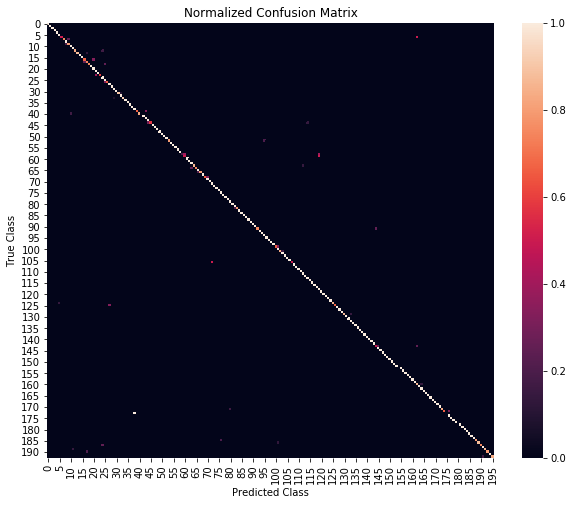

In [29]:
# Evaluation
model_ft_0 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_0.load_state_dict(torch.load(model_dir+'resnet_ensemble_0_pretrained.pt'))
model_ft_1 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_1.load_state_dict(torch.load(model_dir+'resnet_ensemble_1_pretrained.pt'))
model_ft_2 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_2.load_state_dict(torch.load(model_dir+'resnet_ensemble_2_pretrained.pt'))
model_ft_3 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_3.load_state_dict(torch.load(model_dir+'resnet_ensemble_3_pretrained.pt'))
model_ft_4 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_4.load_state_dict(torch.load(model_dir+'resnet_ensemble_4_pretrained.pt'))

correct_1 = 0.0
correct_5 = 0.0
confusion_matrix = np.zeros([196,196])
model_ft_0.eval()
model_ft_1.eval()
model_ft_2.eval()
model_ft_3.eval()
model_ft_4.eval()
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
            
        outputs_0 = model_ft_0(images)
        outputs_1 = model_ft_1(images)
        outputs_2 = model_ft_2(images)
        outputs_3 = model_ft_3(images)
        outputs_4 = model_ft_4(images)
        outputs = outputs_0.data+outputs_1.data+outputs_2.data+outputs_3.data+outputs_4.data
        _, pred_1 = torch.max(outputs, 1)
        correct_1 += (pred_1 == labels).sum().item()
        for ind,x in enumerate(pred_1):
            confusion_matrix[labels[ind],x] += 1 
            
        _, pred_5 = torch.topk(outputs, 5, dim=1)
        pred_5 = pred_5.t()
        for pred in pred_5:
            correct_5 += (pred == labels).sum().item()
        
error_1 = 100.0 * (1 - correct_1/testloader.batch_size/len(testloader))
error_5 = 100.0 * (1 - correct_5/testloader.batch_size/len(testloader))
print('Top 1 error rate on the test images: %.4f %%' % error_1)
print('Top 5 error rate on the test images: %.4f %%' % error_5)

# Visualization
for i, v in enumerate(confusion_matrix):
    if v[i]<0.9:
        print(i,v[i])
    if sum(v) == 0:
        print("$d line sum = 0"%i)
confusion_matrix = [v/sum(v) for v in confusion_matrix if sum(v) != 0]
fig = plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
fig.savefig(img_dir+'cfm_'+model.name+'ensemble.png', bbox_inches='tight')

In [85]:
# Evaluation
model_ft_0 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_0.load_state_dict(torch.load(model_dir+'resnet_ensemble_0_pretrained.pt'))
model_ft_1 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_1.load_state_dict(torch.load(model_dir+'resnet_ensemble_1_pretrained.pt'))
model_ft_2 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_2.load_state_dict(torch.load(model_dir+'resnet_ensemble_2_pretrained.pt'))
model_ft_3 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_3.load_state_dict(torch.load(model_dir+'resnet_ensemble_3_pretrained.pt'))
model_ft_4 = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft_4.load_state_dict(torch.load(model_dir+'resnet_ensemble_4_pretrained.pt'))

correct_1 = 0.0
correct_5 = 0.0
confusion_matrix = np.zeros([196,196])
model_ft_0.eval()
model_ft_1.eval()
model_ft_2.eval()
model_ft_3.eval()
model_ft_4.eval()
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
            
        outputs_0 = model_ft_0(images)
        outputs_1 = model_ft_1(images)
        outputs_2 = model_ft_2(images)
        outputs_3 = model_ft_3(images)
        outputs_4 = model_ft_4(images)
        outputs = outputs_0.data+outputs_1.data+outputs_2.data+outputs_3.data+outputs_4.data
        _, pred_1 = torch.max(outputs, 1)
        correct_1 += (pred_1 == labels).sum().item()
        for ind,x in enumerate(pred_1):
            confusion_matrix[labels[ind],x] += 1 
            
        _, pred_5 = torch.topk(outputs, 5, dim=1)
        pred_5 = pred_5.t()
        for pred in pred_5:
            correct_5 += (pred == labels).sum().item()
        
error_1 = 100.0 * (1 - correct_1/testloader.batch_size/len(testloader))
error_5 = 100.0 * (1 - correct_5/testloader.batch_size/len(testloader))
print('Top 1 error rate on the test images: %.4f %%' % error_1)
print('Top 5 error rate on the test images: %.4f %%' % error_5)
'''
# Visualization
poor_matrix = []
y_tick = []
for i, v in enumerate(confusion_matrix):
    if sum(v) == 0:
        #print("%d line sum = 0"%i)
        pass
    else:
        v = v/sum(v)
        if v[i]<0.9:
            print(i,v[i])
            poor_matrix.append(v)
            y_tick.append(i)

fig = plt.figure(figsize=(10,8))
sns.heatmap(poor_matrix)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
confusion_matrix = [v/sum(v) for v in confusion_matrix if sum(v) != 0]
fig = plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
'''

Top 1 error rate on the test images: 7.9327 %
Top 5 error rate on the test images: 3.4856 %


'\n# Visualization\npoor_matrix = []\ny_tick = []\nfor i, v in enumerate(confusion_matrix):\n    if sum(v) == 0:\n        #print("%d line sum = 0"%i)\n        pass\n    else:\n        v = v/sum(v)\n        if v[i]<0.9:\n            print(i,v[i])\n            poor_matrix.append(v)\n            y_tick.append(i)\n\nfig = plt.figure(figsize=(10,8))\nsns.heatmap(poor_matrix)\nplt.xlabel("Predicted Class")\nplt.ylabel("True Class")\nplt.title("Normalized Confusion Matrix")\nconfusion_matrix = [v/sum(v) for v in confusion_matrix if sum(v) != 0]\nfig = plt.figure(figsize=(10,8))\nsns.heatmap(confusion_matrix)\nplt.xlabel("Predicted Class")\nplt.ylabel("True Class")\nplt.title("Normalized Confusion Matrix")\n'

In [87]:
with open(para_dir+model.name+model.use_pretrained+'_ensemble.pickle', 'wb') as f:
        pickle.dump(confusion_matrix, f)

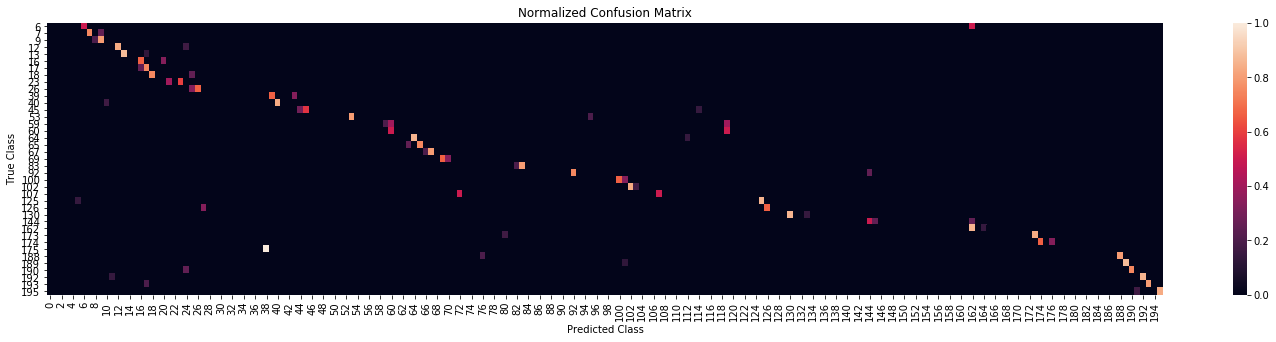

In [94]:
fig = plt.figure(figsize=(25,5))
sns.heatmap(poor_matrix, yticklabels= y_tick)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
fig.savefig(img_dir+'cfm_'+model.name+'ensemble_poor.png', bbox_inches='tight')

<BarContainer object of 39 artists>

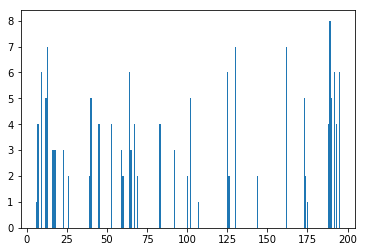

In [139]:
plt.bar(y_tick, sum(confusion_matrix,0)[y_tick])

In [159]:
images = 
images = images.to(device)
labels = labels.to(device)
output = model(images)
conf, predicted = torch.max(output.data, 1)
img = show_tfms(images[1,:,:,:].cpu())
x_grid=utils.make_grid(img, nrow=1, padding=2)
y_grid = classes[predicted[0].item()
fig = plt.figure(figsize=(15,15))
show(x_grid,y_grid,True)

'GMC Savana Van 2012'

In [110]:
sum(confusion_matrix)

array([ 3.,  5.,  3.,  1.,  2.,  6.,  1.,  4.,  4.,  6.,  6.,  1.,  5.,
        7.,  3.,  6.,  3.,  3.,  3.,  4.,  3.,  4.,  7.,  3.,  3.,  4.,
        2.,  5.,  7.,  3.,  4.,  9.,  2., 11.,  4.,  1.,  2.,  2.,  1.,
        2.,  5.,  1.,  5.,  3.,  6.,  4.,  2.,  4.,  4.,  5.,  5.,  6.,
        4.,  4.,  2.,  3.,  5.,  6.,  7.,  3.,  2.,  2.,  3.,  6.,  6.,
        3.,  5.,  4.,  3.,  2.,  5.,  4.,  9.,  2.,  7.,  4.,  3.,  3.,
        3.,  3.,  1.,  5.,  2.,  4.,  6.,  3.,  3.,  5.,  2.,  6.,  8.,
        6.,  3.,  3.,  4.,  6.,  2.,  6.,  3.,  7.,  2.,  4.,  5.,  6.,
        5.,  7.,  3.,  1.,  4.,  6.,  3.,  2., 10.,  5.,  9.,  6.,  4.,
        4.,  2.,  9.,  2.,  3.,  7.,  5.,  4.,  6.,  2.,  6.,  9.,  5.,
        7.,  2.,  2.,  5.,  2.,  2.,  2.,  1.,  3.,  5.,  4.,  1.,  4.,
        9.,  2.,  3.,  6.,  6.,  5.,  3.,  3.,  5.,  1.,  5.,  0.,  5.,
        3.,  6.,  7.,  4.,  7.,  2.,  7.,  4.,  6.,  3.,  6.,  6.,  5.,
        3.,  1.,  6.,  4.,  5.,  2.,  1.,  4.,  4.,  4.,  3.,  0

Epoch 1/30, duration: 127 s, loss: 5.2711, accuracy: 1.1538 %
Accuracy of the network on the validation set: 1.3221 %
save the best model.
Current learning rate: 0.01000
Epoch 2/30, duration: 125 s, loss: 5.0708, accuracy: 2.0467 %
Accuracy of the network on the validation set: 3.1250 %
save the best model.
Current learning rate: 0.01000
Epoch 3/30, duration: 131 s, loss: 4.9360, accuracy: 3.3997 %
Accuracy of the network on the validation set: 3.0048 %
save the best model.
Current learning rate: 0.01000
Epoch 4/30, duration: 124 s, loss: 4.7387, accuracy: 4.5673 %
Accuracy of the network on the validation set: 4.6875 %
save the best model.
Current learning rate: 0.01000
Epoch 5/30, duration: 130 s, loss: 4.4467, accuracy: 6.8819 %
Accuracy of the network on the validation set: 5.2885 %
Current learning rate: 0.01000
Epoch 6/30, duration: 125 s, loss: 4.1407, accuracy: 9.4368 %
Accuracy of the network on the validation set: 9.8558 %
save the best model.
Current learning rate: 0.01000
E

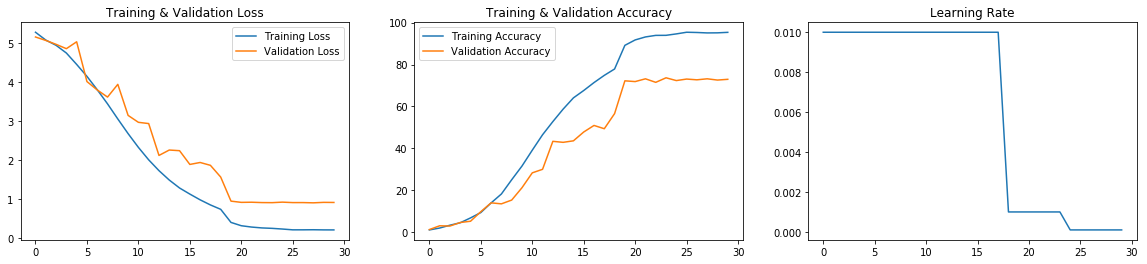

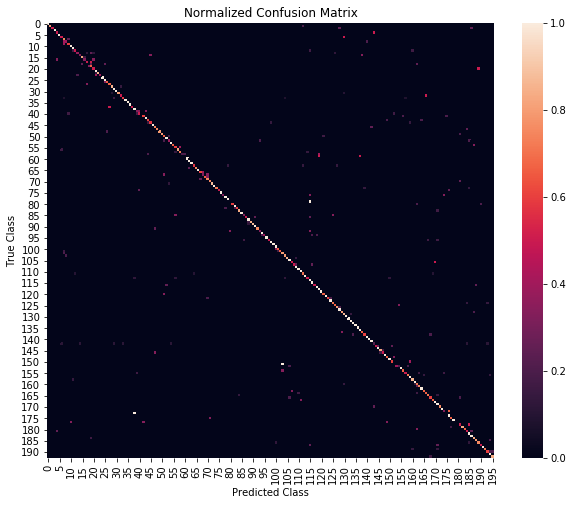

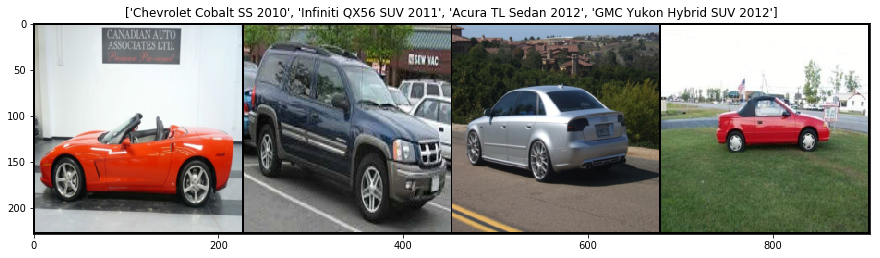

In [29]:
# From Scratch
model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=False)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=30, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

## ResNet34

Epoch 1/15, duration: 147 s, loss: 3.1874, accuracy: 26.5316 %
Accuracy of the network on the validation set: 44.8317 %
save the best model.
Current learning rate: 0.01000
Epoch 2/15, duration: 148 s, loss: 1.3717, accuracy: 60.7074 %
Accuracy of the network on the validation set: 55.5288 %
save the best model.
Current learning rate: 0.01000
Epoch 3/15, duration: 148 s, loss: 0.9006, accuracy: 73.1662 %
Accuracy of the network on the validation set: 64.4231 %
save the best model.
Current learning rate: 0.01000
Epoch 4/15, duration: 148 s, loss: 0.6293, accuracy: 80.9478 %
Accuracy of the network on the validation set: 65.6250 %
Current learning rate: 0.01000
Epoch 5/15, duration: 149 s, loss: 0.4736, accuracy: 85.1511 %
Accuracy of the network on the validation set: 73.1971 %
save the best model.
Current learning rate: 0.00100
Epoch 6/15, duration: 149 s, loss: 0.2050, accuracy: 93.9080 %
Accuracy of the network on the validation set: 85.3365 %
save the best model.
Current learning rat

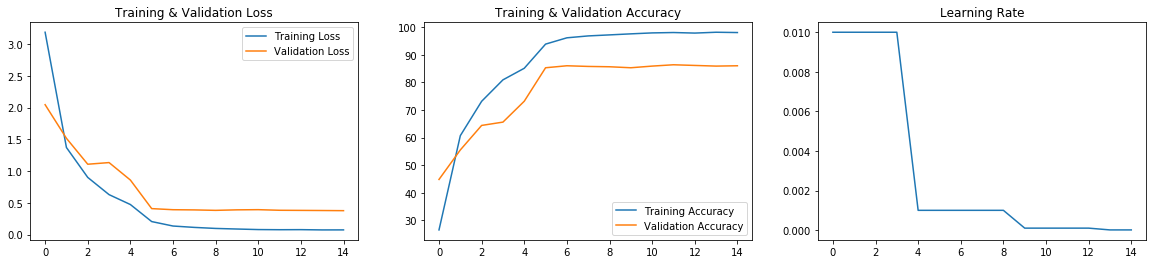

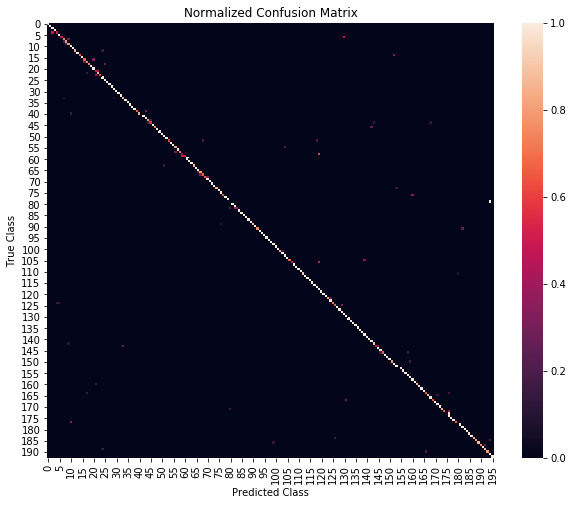

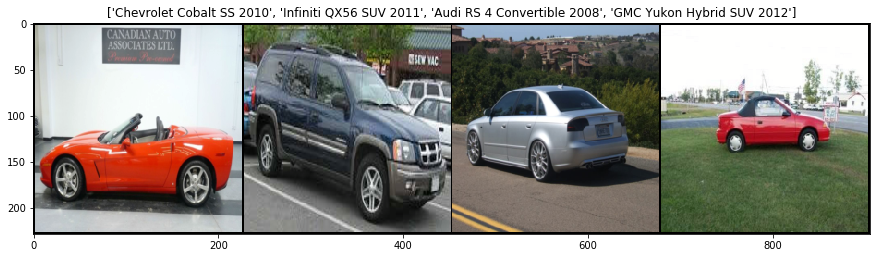

In [31]:
model_ft = init_model('resnet34', num_classes, feature_extract=False, use_pretrained=True)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',patience=3, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=15, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

Epoch 1/30, duration: 144 s, loss: 5.3394, accuracy: 0.6662 %
Accuracy of the network on the validation set: 0.9615 %
save the best model.
Current learning rate: 0.01000
Epoch 2/30, duration: 147 s, loss: 5.1488, accuracy: 1.1813 %
Accuracy of the network on the validation set: 2.1635 %
save the best model.
Current learning rate: 0.01000
Epoch 3/30, duration: 148 s, loss: 5.0531, accuracy: 1.7102 %
Accuracy of the network on the validation set: 3.2452 %
save the best model.
Current learning rate: 0.01000
Epoch 4/30, duration: 147 s, loss: 4.8438, accuracy: 2.8091 %
Accuracy of the network on the validation set: 2.2837 %
Current learning rate: 0.01000
Epoch 5/30, duration: 148 s, loss: 4.5637, accuracy: 4.5879 %
Accuracy of the network on the validation set: 4.0865 %
save the best model.
Current learning rate: 0.01000
Epoch 6/30, duration: 148 s, loss: 4.2128, accuracy: 7.0879 %
Accuracy of the network on the validation set: 6.9712 %
Current learning rate: 0.01000
Epoch 7/30, duration: 

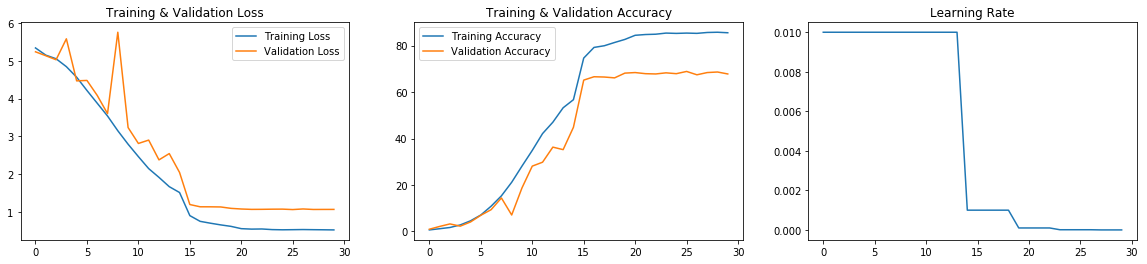

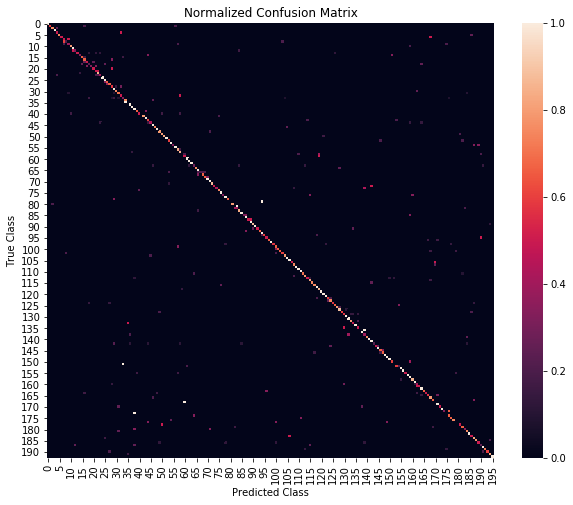

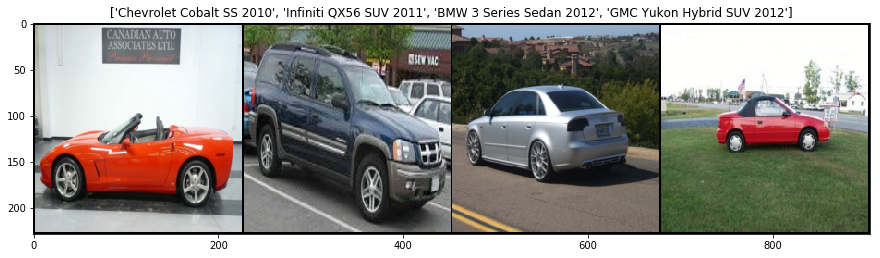

In [32]:
model_ft = init_model('resnet34', num_classes, feature_extract=False, use_pretrained=False)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=30, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

## ResNet50

In [27]:
model_ft = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft.name = 'resnet_50_ensemble_0'
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=15, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

Epoch 1/15, duration: 243 s, loss: 3.0632, accuracy: 28.8049 %
Accuracy of the network on the validation set: 43.8702 %
save the best model.
Current learning rate: 0.01000
Epoch 2/15, duration: 244 s, loss: 1.3356, accuracy: 61.3049 %
Accuracy of the network on the validation set: 57.9327 %
save the best model.
Current learning rate: 0.01000
Epoch 3/15, duration: 245 s, loss: 0.8447, accuracy: 74.7321 %
Accuracy of the network on the validation set: 70.9135 %
save the best model.
Current learning rate: 0.01000
Epoch 4/15, duration: 245 s, loss: 0.6221, accuracy: 80.7967 %
Accuracy of the network on the validation set: 65.7452 %
Current learning rate: 0.01000
Epoch 5/15, duration: 245 s, loss: 0.4880, accuracy: 85.0893 %
Accuracy of the network on the validation set: 73.1971 %
save the best model.
Current learning rate: 0.00100
Epoch 6/15, duration: 245 s, loss: 0.2029, accuracy: 94.1140 %
Accuracy of the network on the validation set: 85.4567 %
save the best model.
Current learning rat

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Epoch 1/30, duration: 249 s, loss: 5.3353, accuracy: 0.8173 %
Accuracy of the network on the validation set: 0.9615 %
save the best model.
Current learning rate: 0.00100
Epoch 2/30, duration: 251 s, loss: 5.1740, accuracy: 1.1676 %
Accuracy of the network on the validation set: 2.5240 %
save the best model.
Current learning rate: 0.00100
Epoch 3/30, duration: 252 s, loss: 5.0992, accuracy: 1.5041 %
Accuracy of the network on the validation set: 2.4038 %
save the best model.
Current learning rate: 0.00100
Epoch 4/30, duration: 251 s, loss: 5.0018, accuracy: 2.5137 %
Accuracy of the network on the validation set: 2.6442 %
save the best model.
Current learning rate: 0.00100
Epoch 5/30, duration: 252 s, loss: 4.9140, accuracy: 2.9464 %
Accuracy of the network on the validation set: 2.6442 %
save the best model.
Current learning rate: 0.00100
Epoch 6/30, duration: 252 s, loss: 4.7513, accuracy: 4.1209 %
Accuracy of the network on the validation set: 2.2837 %
Current learning rate: 0.00100
E

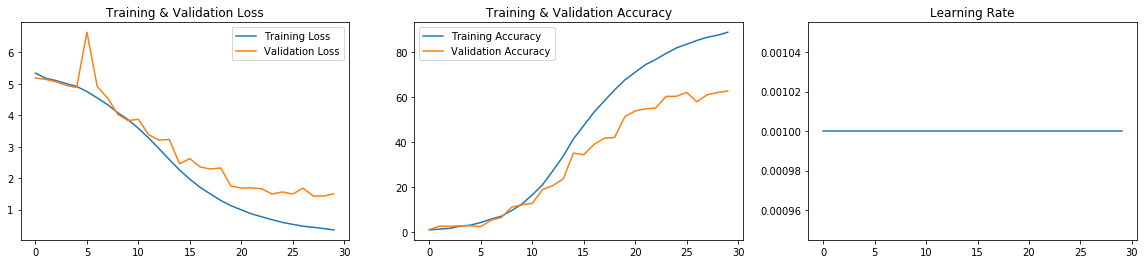

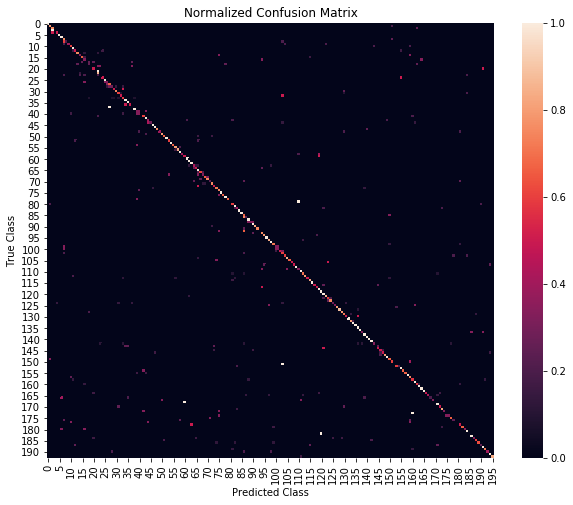

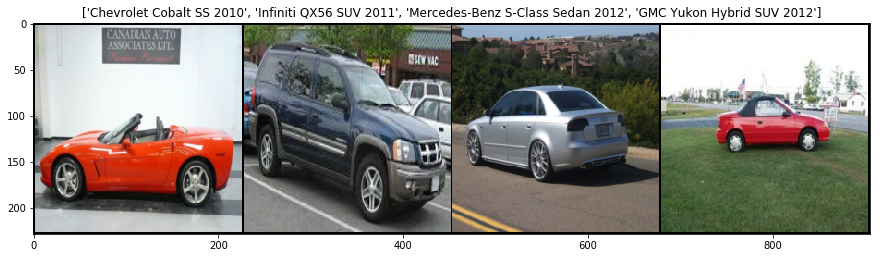

In [36]:
model_ft = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=False)
loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
#lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=30, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

## Customized AlexNet

In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=196):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
def alexnet(pretrained=False, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = torch.load(model_dir+'alexnet_pretrained.pt')
        model.features[0].weight.data = state_dict['features.0.weight']
        model.features[3].weight.data = state_dict['features.3.weight']
        #model.features[6].weight.data = state_dict['features.6.weight']
        #model.features[8].weight.data = state_dict['features.8.weight']
        #model.features[10].weight.data = state_dict['features.10.weight']
        
    return model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 256, 13, 13]         442,624
              ReLU-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         590,080
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

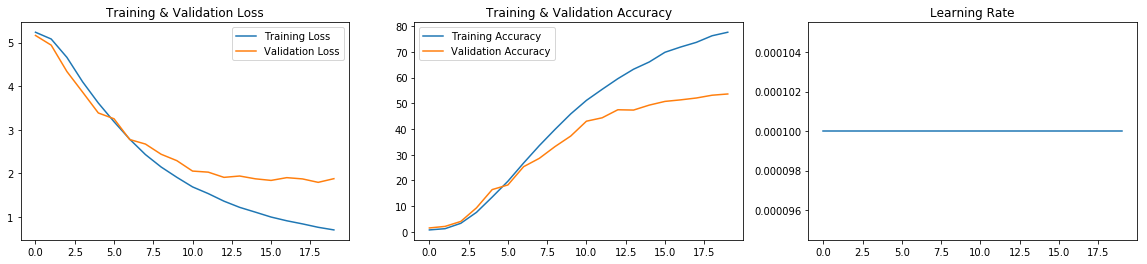

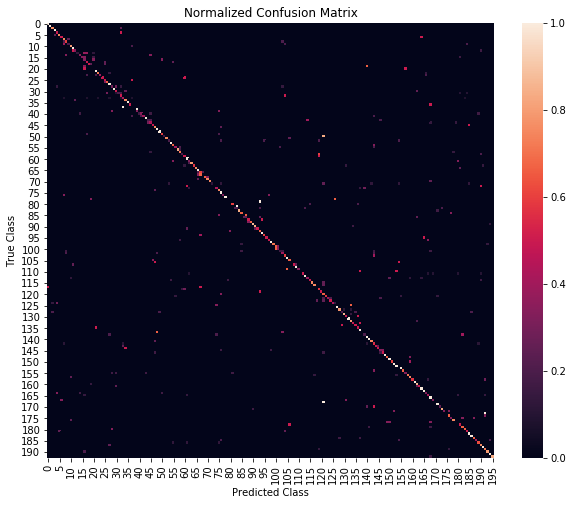

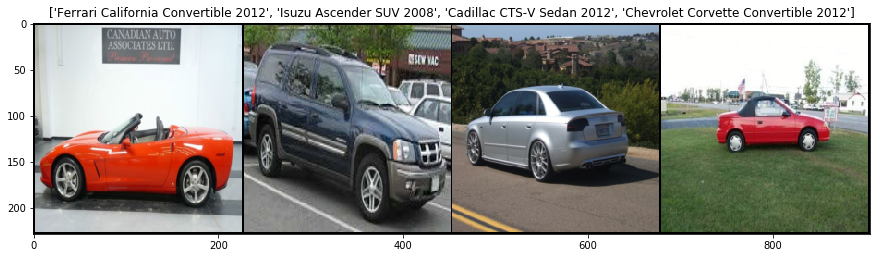

In [19]:
model_ft = alexnet(pretrained=True)
model_ft = model_ft.to(device)
model_ft.name="alexnet_reducded"
model_ft.use_pretrained = "false"
loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
summary(model_ft, input_size=(3, 224, 224))
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=20, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

In [28]:
model_ft.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [29]:
state_dict = torch.load(model_dir+'alexnet_pretrained.pt')

In [32]:
state_dict['features.3.weight']

tensor([[[[ 6.9212e-03,  1.9075e-04,  3.4184e-02, -2.3659e-02, -4.3387e-03],
          [ 2.7860e-02, -8.9722e-03,  7.3198e-02, -8.6096e-02,  1.0412e-02],
          [ 1.8630e-02, -1.0481e-01,  2.1261e-02, -7.3585e-02,  3.3401e-02],
          [-7.1721e-03, -3.2697e-02, -4.5779e-02,  1.8409e-02, -9.5580e-04],
          [-2.0334e-02,  9.2310e-03,  2.4480e-02,  6.0007e-03, -9.8053e-03]],

         [[-5.4469e-03, -1.7361e-02, -3.3817e-02, -2.4195e-02, -1.3755e-02],
          [-7.3430e-03,  3.1485e-02,  2.9678e-02, -8.8103e-03, -1.8035e-02],
          [ 2.2953e-03,  7.3863e-02,  4.9753e-02,  6.2810e-03,  2.0798e-02],
          [-2.7979e-02,  2.6877e-03,  2.9558e-02, -1.0965e-02,  1.0165e-03],
          [ 6.3289e-03, -3.4704e-02, -6.5798e-03, -1.5164e-02,  9.9091e-03]],

         [[-1.4119e-02, -5.7321e-02, -9.4628e-02,  1.7598e-02,  5.2170e-02],
          [-1.5578e-02, -1.1044e-01, -2.0398e-02,  4.0913e-02,  5.0546e-02],
          [-1.1136e-02,  4.2267e-02,  2.1744e-01,  3.8307e-02, -5.1331e-

In [12]:
model_ft = init_model('alexnet', num_classes, feature_extract=False, use_pretrained=True)
summary(model_ft, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## AlexNet

Epoch 1/20, duration: 113 s, loss: 4.3682, accuracy: 9.5055 %
Accuracy of the network on the validation set: 22.2356 %
save the best model.
Current learning rate: 0.00010
Epoch 2/20, duration: 120 s, loss: 2.7624, accuracy: 31.3599 %
Accuracy of the network on the validation set: 34.0144 %
save the best model.
Current learning rate: 0.00010
Epoch 3/20, duration: 121 s, loss: 1.9891, accuracy: 47.3077 %
Accuracy of the network on the validation set: 43.1490 %
save the best model.
Current learning rate: 0.00010
Epoch 4/20, duration: 126 s, loss: 1.5145, accuracy: 57.8365 %
Accuracy of the network on the validation set: 47.2356 %
save the best model.
Current learning rate: 0.00010
Epoch 5/20, duration: 123 s, loss: 1.1912, accuracy: 66.1538 %
Accuracy of the network on the validation set: 51.0817 %
save the best model.
Current learning rate: 0.00010
Epoch 6/20, duration: 125 s, loss: 0.9423, accuracy: 71.9918 %
Accuracy of the network on the validation set: 51.5625 %
save the best model.


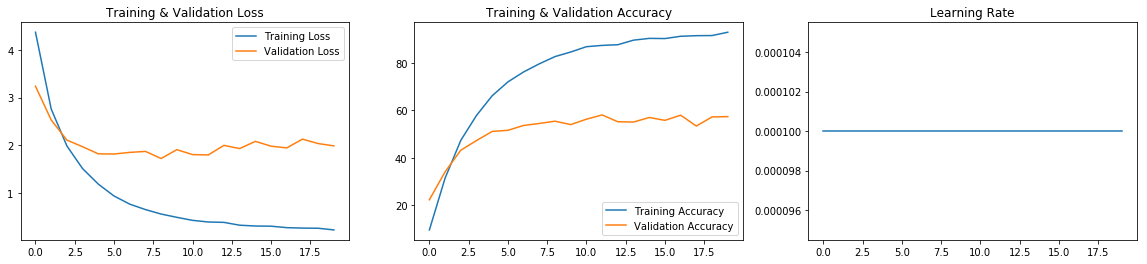

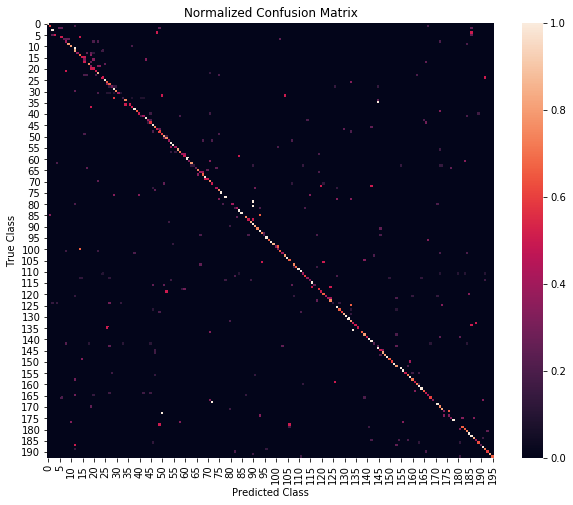

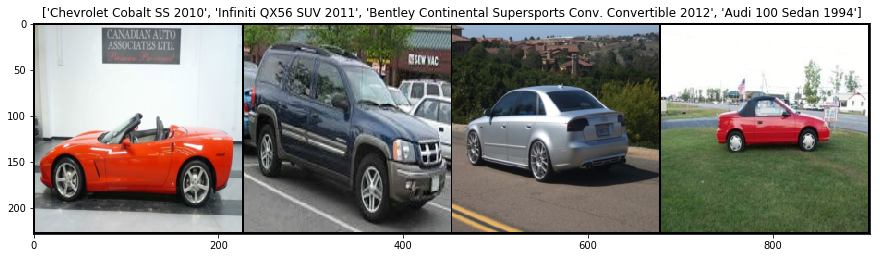

In [40]:
model_ft = init_model('alexnet', num_classes, feature_extract=False, use_pretrained=True)
loss = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold = 0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=20, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

In [118]:
model_ft = init_model('alexnet', num_classes, feature_extract=False, use_pretrained=False)
loss = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
#lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=35, export_onnx = False)
# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)
# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

KeyboardInterrupt: 

## GoogLeNet

/home/yi/.local/lib/python3.6/site-packages/torchvision/models/googlenet.py:46: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '


Epoch 1/20, duration: 361 s, loss: 8.2598, accuracy: 4.7184 %
Accuracy of the network on the validation set: 14.3029 %
save the best model.
Current learning rate: 0.01000
Epoch 2/20, duration: 123 s, loss: 7.1090, accuracy: 22.2734 %
Accuracy of the network on the validation set: 28.4856 %
save the best model.
Current learning rate: 0.01000
Epoch 3/20, duration: 129 s, loss: 5.8666, accuracy: 41.7102 %
Accuracy of the network on the validation set: 49.5192 %
save the best model.
Current learning rate: 0.01000
Epoch 4/20, duration: 130 s, loss: 4.7967, accuracy: 57.4313 %
Accuracy of the network on the validation set: 60.4567 %
save the best model.
Current learning rate: 0.01000
Epoch 5/20, duration: 132 s, loss: 3.9484, accuracy: 67.3146 %
Accuracy of the network on the validation set: 66.2260 %
save the best model.
Current learning rate: 0.01000
Epoch 6/20, duration: 133 s, loss: 3.3157, accuracy: 74.4643 %
Accuracy of the network on the validation set: 57.8125 %
Current learning rate

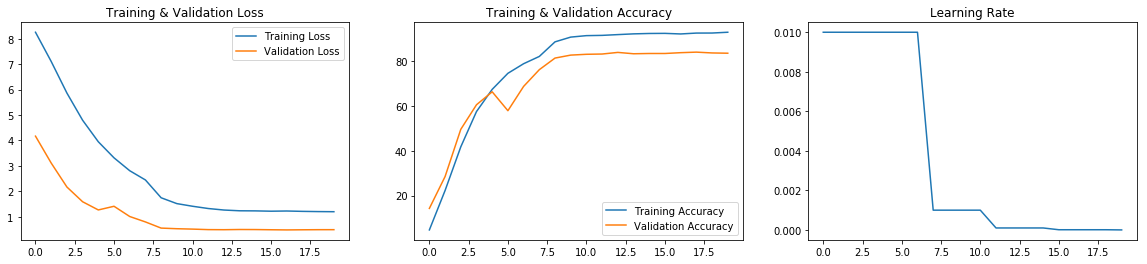

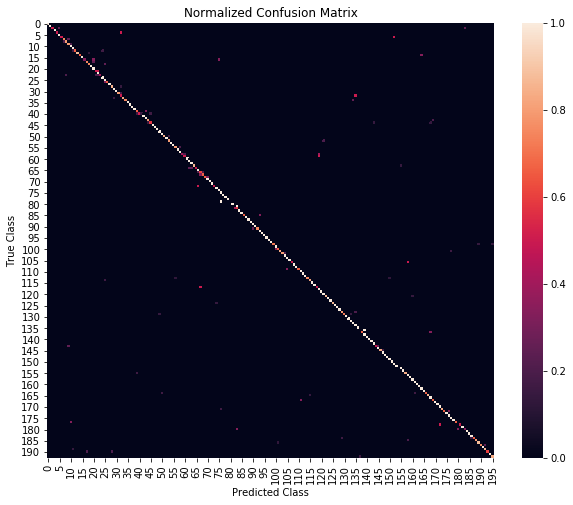

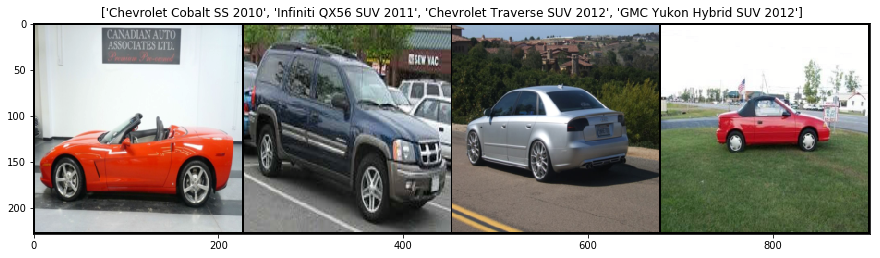

In [10]:
model_ft = init_model('googlenet', num_classes, feature_extract=False, use_pretrained=True)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=20, export_onnx = False)

# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)

# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

Epoch 1/30, duration: 127 s, loss: 8.3322, accuracy: 1.7376 %
Accuracy of the network on the validation set: 2.6442 %
save the best model.
Current learning rate: 0.00010
Epoch 2/30, duration: 138 s, loss: 8.0450, accuracy: 3.2624 %
Accuracy of the network on the validation set: 3.4856 %
save the best model.
Current learning rate: 0.00010
Epoch 3/30, duration: 139 s, loss: 7.6141, accuracy: 5.3022 %
Accuracy of the network on the validation set: 5.0481 %
save the best model.
Current learning rate: 0.00010
Epoch 4/30, duration: 139 s, loss: 7.0774, accuracy: 7.7953 %
Accuracy of the network on the validation set: 8.0529 %
save the best model.
Current learning rate: 0.00010
Epoch 5/30, duration: 135 s, loss: 6.5550, accuracy: 11.7995 %
Accuracy of the network on the validation set: 11.6587 %
save the best model.
Current learning rate: 0.00010
Epoch 6/30, duration: 136 s, loss: 6.0921, accuracy: 15.8104 %
Accuracy of the network on the validation set: 16.5865 %
save the best model.
Current

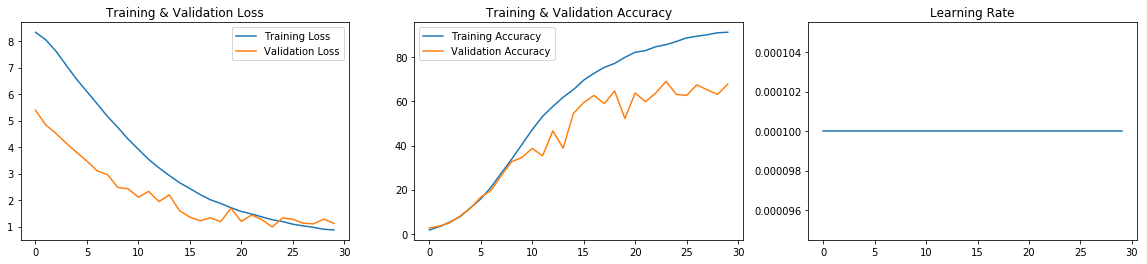

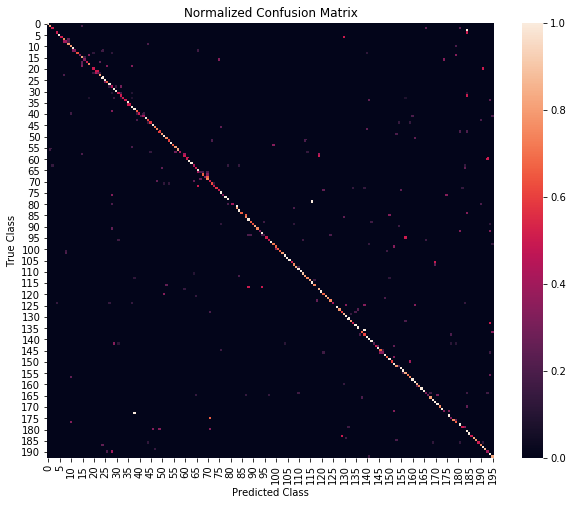

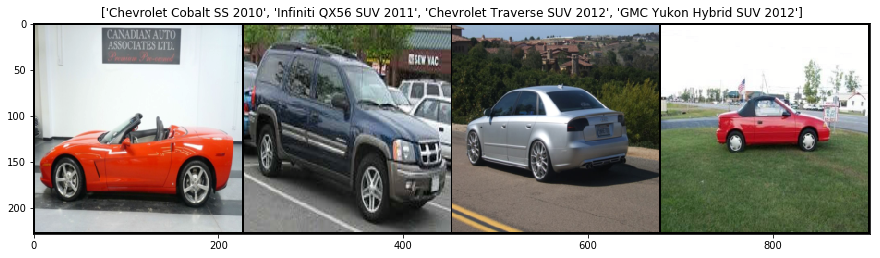

In [13]:
model_ft = init_model('googlenet', num_classes, feature_extract=False, use_pretrained=False)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=30, threshold = 0.9)

# Training
model_ft, training_loss, training_acc, val_loss, val_acc, lr = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=30, export_onnx = False)

# Evaluation
model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)

# Visualization
visual_results(model_ft, training_loss, training_acc, val_loss, val_acc, lr, error_1, error_5, confusion_matrix)

## Effect of data augmentation

In [41]:
training_loss = np.zeros([2,10])
training_acc = np.zeros([2,10])
val_loss  = np.zeros([2,10])
val_acc  = np.zeros([2,10])
lr  = np.zeros([2,10])

# apply transformations
train_ds = MapDataset(train_ds, train_tfms)
val_ds = MapDataset(val_ds, val_tfms)
test_ds = MapDataset(test_ds, test_tfms)

# dataloaders
trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
valloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)
testloader = DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers = 2)

loss = nn.CrossEntropyLoss()
model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=False)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
model_ft, training_loss[0], training_acc[0], val_loss[0], val_acc[0], lr[0] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=10, export_onnx = False)

model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)

# no augmentation
train_ds = MapDataset(train_ds, data_tfms)
val_ds = MapDataset(val_ds, data_tfms)
test_ds = MapDataset(test_ds, data_tfms)

# dataloaders
trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
valloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)
testloader = DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers = 2)


loss = nn.CrossEntropyLoss()
model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=False)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
model_ft, training_loss[1], training_acc[1], val_loss[1], val_acc[1], lr[1] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=10, export_onnx = False)

model_ft.load_state_dict(torch.load(model_dir+model_ft.name+model_ft.use_pretrained+'.pt'))
error_1, error_5, confusion_matrix = eval_model(model_ft)

f, axarr = plt.subplots(1,2,figsize=(18,6))
axarr[0].plot(training_loss[0], label='With data augmentation:Training Loss')
axarr[0].plot(val_loss[0], label='With data augmentation:Validation Loss')
axarr[0].plot(training_loss[1], label='Without data augmentation:Training Loss')
axarr[0].plot(val_loss[1], label='Without data augmentation:Validation Loss')
axarr[0].legend()
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[0], label='With data augmentation:Training Loss')
axarr[1].plot(val_acc[0], label='With data augmentation:Validation Loss')
axarr[1].plot(training_acc[1], label='Without data augmentation:Training Loss')
axarr[1].plot(val_acc[1], label='Without data augmentation:Validation Loss')
axarr[1].legend()
axarr[1].set_title("Training & Validation Accuracy")

f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_data_aug.png', bbox_inches='tight')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/yi/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/yi/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/yi/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-19-ba72dc38d227>", line 23, in __getitem__
    return self.map(self.dataset[index][0]), self.dataset[index][1]
  File "/home/yi/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 70, in __call__
    img = t(img)
  File "/home/yi/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 207, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/home/yi/.local/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 239, in resize
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
TypeError: img should be PIL Image. Got <class 'torch.Tensor'>


## Effect of learning rate

Epoch 1/5, duration: 390 s, loss: 5.2753, accuracy: 1.0234 %
Accuracy of the network on the validation set: 1.6827 %
save the best model.
Current learning rate: 0.10000
Epoch 2/5, duration: 121 s, loss: 5.1466, accuracy: 1.6071 %
Accuracy of the network on the validation set: 1.8029 %
save the best model.
Current learning rate: 0.10000
Epoch 3/5, duration: 129 s, loss: 5.0835, accuracy: 2.0055 %
Accuracy of the network on the validation set: 3.0048 %
save the best model.
Current learning rate: 0.10000
Epoch 4/5, duration: 128 s, loss: 5.0161, accuracy: 2.5549 %
Accuracy of the network on the validation set: 3.4856 %
save the best model.
Current learning rate: 0.10000
Epoch 5/5, duration: 129 s, loss: 4.9197, accuracy: 3.2418 %
Accuracy of the network on the validation set: 2.6442 %
save the best model.
Current learning rate: 0.10000
Finished Training
Epoch 1/5, duration: 132 s, loss: 5.2808, accuracy: 1.1332 %
Accuracy of the network on the validation set: 1.9231 %
save the best model.

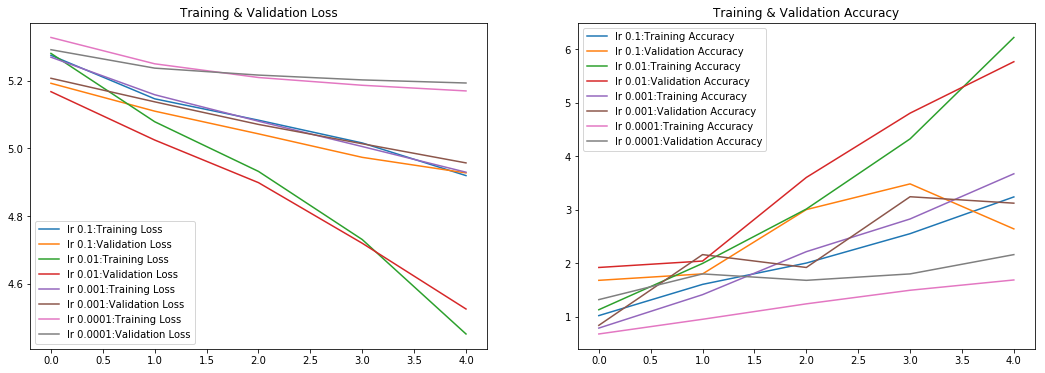

In [9]:
training_loss = np.zeros([4,5])
training_acc = np.zeros([4,5])
val_loss  = np.zeros([4,5])
val_acc  = np.zeros([4,5])
lr  = np.zeros([4,5])
loss = nn.CrossEntropyLoss()

base_lr = [0.1, 0.01, 0.001, 0.0001]
#torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01)

for i in range(4):
    model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=False)
    l = base_lr[i]
    optimizer = optim.SGD(model_ft.parameters(), lr=l, momentum=0.9)
    lrscheduler = optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
    # Training
    model_lr, training_loss[i], training_acc[i], val_loss[i], val_acc[i], lr[i] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=5, export_onnx = False)

f, axarr = plt.subplots(1,2,figsize=(18,6))
axarr[0].plot(training_loss[0], label='lr 0.1:Training Loss')
axarr[0].plot(val_loss[0], label='lr 0.1:Validation Loss')
axarr[0].plot(training_loss[1], label='lr 0.01:Training Loss')
axarr[0].plot(val_loss[1], label='lr 0.01:Validation Loss')
axarr[0].plot(training_loss[2], label='lr 0.001:Training Loss')
axarr[0].plot(val_loss[2], label='lr 0.001:Validation Loss')
axarr[0].plot(training_loss[3], label='lr 0.0001:Training Loss')
axarr[0].plot(val_loss[3], label='lr 0.0001:Validation Loss')  
axarr[0].legend()
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[0], label='lr 0.1:Training Accuracy')
axarr[1].plot(val_acc[0], label='lr 0.1:Validation Accuracy')
axarr[1].plot(training_acc[1], label='lr 0.01:Training Accuracy')
axarr[1].plot(val_acc[1], label='lr 0.01:Validation Accuracy')
axarr[1].plot(training_acc[2], label='lr 0.001:Training Accuracy')
axarr[1].plot(val_acc[2], label='lr 0.001:Validation Accuracy')
axarr[1].plot(training_acc[3], label='lr 0.0001:Training Accuracy')
axarr[1].plot(val_acc[3], label='lr 0.0001:Validation Accuracy')  
axarr[1].legend()
axarr[1].set_title("Training & Validation Accuracy")

f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_lr.png', bbox_inches='tight')

## Effect of batch size

In [10]:
training_loss = np.zeros([4,20])
training_acc = np.zeros([4,20])
val_loss  = np.zeros([4,20])
val_acc  = np.zeros([4,20])
lr  = np.zeros([4,10])
loss = nn.CrossEntropyLoss()

#torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01)
d = [4, 8, 16, 32]
for i in range(4):
    trainloader = DataLoader(train_ds, batch_size = d[i], shuffle=True, num_workers = 2)
    valloader = DataLoader(val_ds, batch_size = d[i], shuffle=False, num_workers = 2)
    model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=True)
    #optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
    optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
    # Training
    model_ft, training_loss[i], training_acc[i], val_loss[i], val_acc[i], lr[i] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=20, export_onnx = False)

f, axarr = plt.subplots(1,2,figsize=(18,6))
axarr[0].plot(training_loss[0], label='batch size 4:Training Loss')
axarr[0].plot(val_loss[0], label='batch size 4:Validation Loss')
axarr[0].plot(training_loss[1], label='batch size 8:Training Loss')
axarr[0].plot(val_loss[1], label='batch size 8:Validation Loss')
axarr[0].plot(training_loss[2], label='batch size 16:Training Loss')
axarr[0].plot(val_loss[2], label='batch size 16:Validation Loss')
axarr[0].plot(training_loss[3], label='batch size 32:Training Loss')
axarr[0].plot(val_loss[3], label='batch size 32:Validation Loss')  
axarr[0].legend()
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[0], label='batch size 4:Training Accuracy')
axarr[1].plot(val_acc[0], label='batch size 4:Validation Accuracy')
axarr[1].plot(training_acc[1], label='batch size 8:Training Accuracy')
axarr[1].plot(val_acc[1], label='batch size 8:Validation Accuracy')
axarr[1].plot(training_acc[2], label='batch size 16:Training Accuracy')
axarr[1].plot(val_acc[2], label='batch size 16:Validation Accuracy')
axarr[1].plot(training_acc[3], label='batch size 32:Training Accuracy')
axarr[1].plot(val_acc[3], label='batch size 32:Validation Accuracy')  
axarr[1].legend()
axarr[1].set_title("Training & Validation Accuracy")

f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_batch_size.png', bbox_inches='tight')

Epoch 1/20, duration: 150 s, loss: 3.9882, accuracy: 14.6497 %
Accuracy of the network on the validation set: 40.4703 %
save the best model.
Current learning rate: 0.00100
Epoch 2/20, duration: 153 s, loss: 2.2245, accuracy: 43.8255 %
Accuracy of the network on the validation set: 66.2129 %
save the best model.
Current learning rate: 0.00100
Epoch 3/20, duration: 155 s, loss: 1.5005, accuracy: 59.9657 %
Accuracy of the network on the validation set: 72.8960 %
save the best model.
Current learning rate: 0.00100
Epoch 4/20, duration: 155 s, loss: 1.1125, accuracy: 69.7734 %
Accuracy of the network on the validation set: 77.9703 %
save the best model.
Current learning rate: 0.00100
Epoch 5/20, duration: 157 s, loss: 0.8751, accuracy: 75.2816 %
Accuracy of the network on the validation set: 80.4455 %
save the best model.
Current learning rate: 0.00100
Epoch 6/20, duration: 158 s, loss: 0.7295, accuracy: 79.2514 %
Accuracy of the network on the validation set: 81.3119 %
save the best model.

ValueError: cannot copy sequence with size 20 to array axis with dimension 10

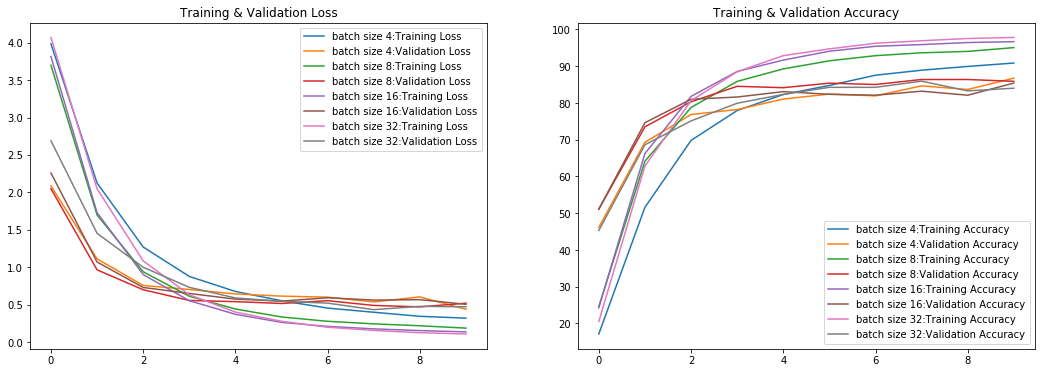

In [8]:
f, axarr = plt.subplots(1,2,figsize=(18,6))
axarr[0].plot(training_loss[0], label='batch size 4:Training Loss')
axarr[0].plot(val_loss[0], label='batch size 4:Validation Loss')
axarr[0].plot(training_loss[1], label='batch size 8:Training Loss')
axarr[0].plot(val_loss[1], label='batch size 8:Validation Loss')
axarr[0].plot(training_loss[2], label='batch size 16:Training Loss')
axarr[0].plot(val_loss[2], label='batch size 16:Validation Loss')
axarr[0].plot(training_loss[3], label='batch size 32:Training Loss')
axarr[0].plot(val_loss[3], label='batch size 32:Validation Loss')  
axarr[0].legend()
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[0], label='batch size 4:Training Accuracy')
axarr[1].plot(val_acc[0], label='batch size 4:Validation Accuracy')
axarr[1].plot(training_acc[1], label='batch size 8:Training Accuracy')
axarr[1].plot(val_acc[1], label='batch size 8:Validation Accuracy')
axarr[1].plot(training_acc[2], label='batch size 16:Training Accuracy')
axarr[1].plot(val_acc[2], label='batch size 16:Validation Accuracy')
axarr[1].plot(training_acc[3], label='batch size 32:Training Accuracy')
axarr[1].plot(val_acc[3], label='batch size 32:Validation Accuracy')  
axarr[1].legend()
axarr[1].set_title("Training & Validation Accuracy")

f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_batch_size.png', bbox_inches='tight')

Epoch 1/20, duration: 119 s, loss: 5.1454, accuracy: 1.7102 %
Accuracy of the network on the validation set: 2.1635 %
save the best model.
Current learning rate: 0.00010
Epoch 2/20, duration: 126 s, loss: 4.8050, accuracy: 4.5192 %
Accuracy of the network on the validation set: 5.4087 %
save the best model.
Current learning rate: 0.00010
Epoch 3/20, duration: 128 s, loss: 4.4435, accuracy: 7.6099 %
Accuracy of the network on the validation set: 7.5721 %
save the best model.
Current learning rate: 0.00010
Epoch 4/20, duration: 130 s, loss: 4.0977, accuracy: 11.4080 %
Accuracy of the network on the validation set: 4.4471 %
Current learning rate: 0.00010
Epoch 5/20, duration: 135 s, loss: 3.7514, accuracy: 15.7967 %
Accuracy of the network on the validation set: 11.8990 %
save the best model.
Current learning rate: 0.00010
Epoch 6/20, duration: 131 s, loss: 3.4174, accuracy: 20.8791 %
Accuracy of the network on the validation set: 13.1010 %
save the best model.
Current learning rate: 0.00

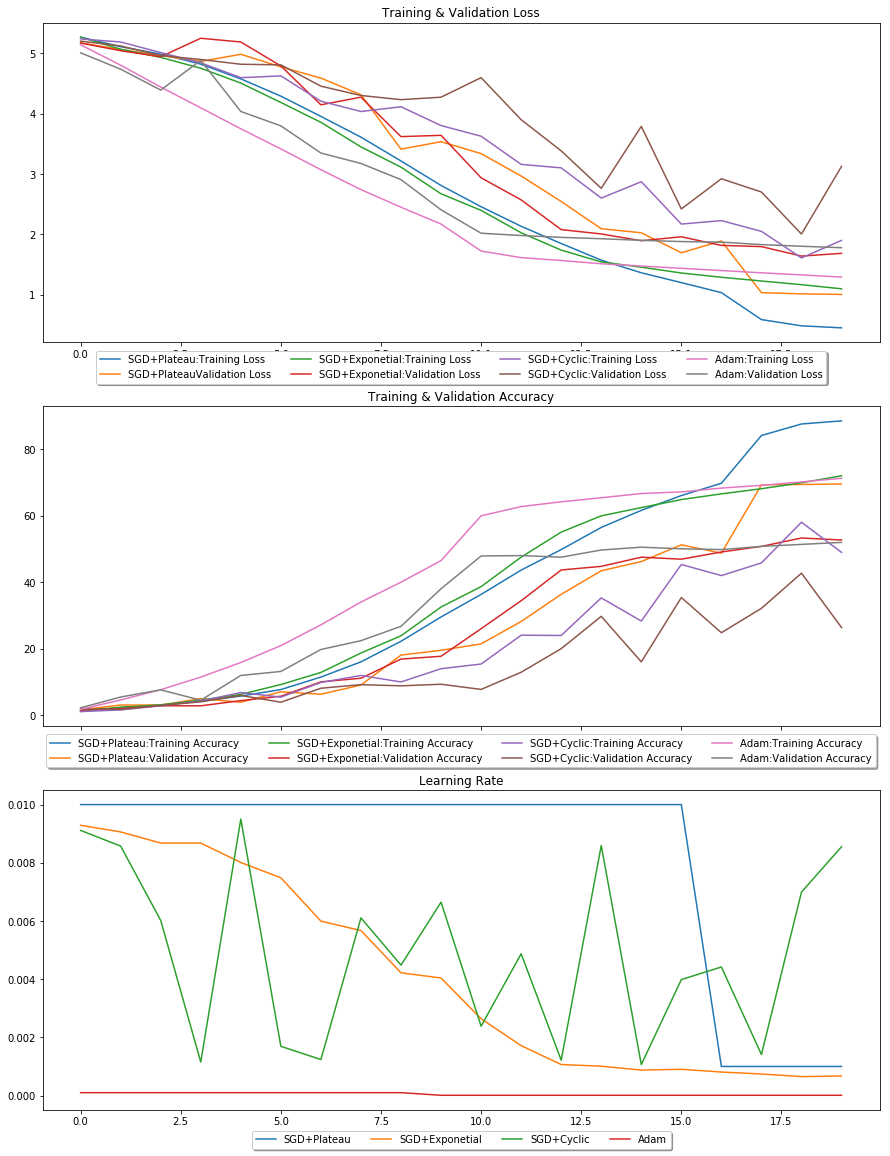

In [92]:
training_loss = np.zeros([4,20])
training_acc = np.zeros([4,20])
val_loss  = np.zeros([4,20])
val_acc  = np.zeros([4,20])
lr  = np.zeros([4,20])
loss = nn.CrossEntropyLoss()

#torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01)
for i in range(4):
    model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=False)
    if i == 3:
      optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
      lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
    elif i == 1:
      optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
      lrscheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
    elif i == 2:
      optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
      lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2, step_size_down=2)
    else:
      optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
      lrscheduler = optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

      
    # Training
    model, training_loss[i], training_acc[i], val_loss[i], val_acc[i], lr[i] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=20, export_onnx = False)

f, axarr = plt.subplots(3,1,figsize=(15,20))
axarr[0].plot(training_loss[3], label='SGD+Plateau:Training Loss')
axarr[0].plot(val_loss[3], label='SGD+PlateauValidation Loss')
axarr[0].plot(training_loss[1], label='SGD+Exponetial:Training Loss')
axarr[0].plot(val_loss[1], label='SGD+Exponetial:Validation Loss')
axarr[0].plot(training_loss[2], label='SGD+Cyclic:Training Loss')
axarr[0].plot(val_loss[2], label='SGD+Cyclic:Validation Loss')
axarr[0].plot(training_loss[0], label='Adam:Training Loss')
axarr[0].plot(val_loss[0], label='Adam:Validation Loss')  
axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=4)
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[3], label='SGD+Plateau:Training Accuracy')
axarr[1].plot(val_acc[3], label='SGD+Plateau:Validation Accuracy')
axarr[1].plot(training_acc[1], label='SGD+Exponetial:Training Accuracy')
axarr[1].plot(val_acc[1], label='SGD+Exponetial:Validation Accuracy')
axarr[1].plot(training_acc[2], label='SGD+Cyclic:Training Accuracy')
axarr[1].plot(val_acc[2], label='SGD+Cyclic:Validation Accuracy')
axarr[1].plot(training_acc[0], label='Adam:Training Accuracy')
axarr[1].plot(val_acc[0], label='Adam:Validation Accuracy')  
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=4)
axarr[1].set_title("Training & Validation Accuracy")
axarr[2].plot(lr[3], label='SGD+Plateau')
axarr[2].plot(lr[1], label='SGD+Exponetial')
axarr[2].plot(lr[2], label='SGD+Cyclic')
axarr[2].plot(lr[0], label='Adam') 
axarr[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=4)
axarr[2].set_title("Learning Rate")


f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_optimizer.png', bbox_inches='tight')

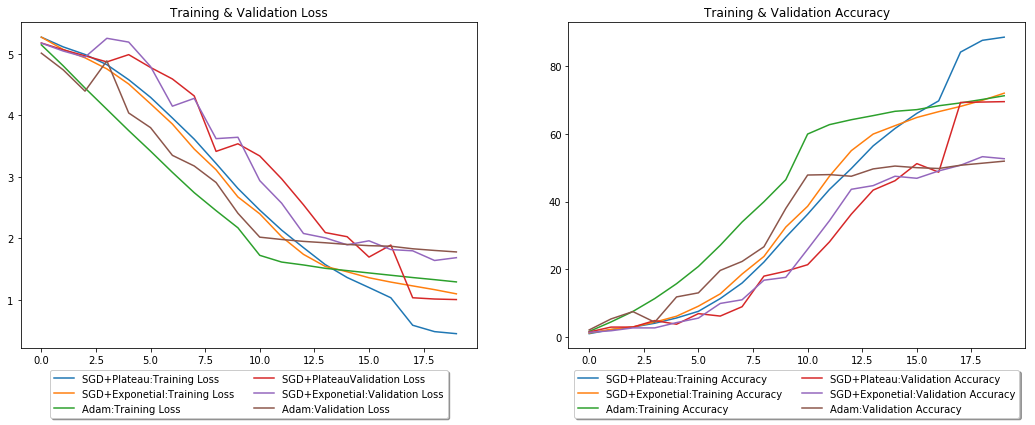

In [101]:
f, axarr = plt.subplots(1,2,figsize=(18,6))
axarr[0].plot(training_loss[3], label='SGD+Plateau:Training Loss')
axarr[0].plot(training_loss[1], label='SGD+Exponetial:Training Loss')
axarr[0].plot(training_loss[0], label='Adam:Training Loss')
axarr[0].plot(val_loss[3], label='SGD+PlateauValidation Loss')

axarr[0].plot(val_loss[1], label='SGD+Exponetial:Validation Loss')

axarr[0].plot(val_loss[0], label='Adam:Validation Loss')  
axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[3], label='SGD+Plateau:Training Accuracy')
axarr[1].plot(training_acc[1], label='SGD+Exponetial:Training Accuracy')
axarr[1].plot(training_acc[0], label='Adam:Training Accuracy')

axarr[1].plot(val_acc[3], label='SGD+Plateau:Validation Accuracy')

axarr[1].plot(val_acc[1], label='SGD+Exponetial:Validation Accuracy')

axarr[1].plot(val_acc[0], label='Adam:Validation Accuracy')  
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
axarr[1].set_title("Training & Validation Accuracy")


f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_optimizer.png', bbox_inches='tight')

Text(0.5, 1.0, 'Learning Rate')

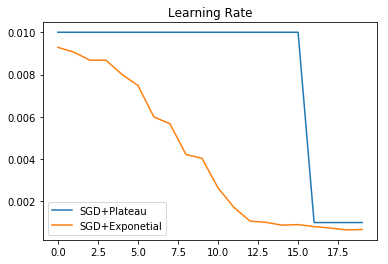

In [105]:
plt.plot(lr[3], label='SGD+Plateau')
plt.plot(lr[1], label='SGD+Exponetial')
plt.legend()
plt.title("Learning Rate")

In [16]:
#lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
#lrscheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2, step_size_down=2)
lrscheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)

for i in range(20):
    lrscheduler.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(("Current learning rate: %.5f")%lr)

Current learning rate: 0.00085
Current learning rate: 0.00072
Current learning rate: 0.00061
Current learning rate: 0.00052
Current learning rate: 0.00044
Current learning rate: 0.00038
Current learning rate: 0.00032
Current learning rate: 0.00027
Current learning rate: 0.00023
Current learning rate: 0.00020
Current learning rate: 0.00017
Current learning rate: 0.00014
Current learning rate: 0.00012
Current learning rate: 0.00010
Current learning rate: 0.00009
Current learning rate: 0.00007
Current learning rate: 0.00006
Current learning rate: 0.00005
Current learning rate: 0.00005
Current learning rate: 0.00004


Epoch 1/10, duration: 117 s, loss: 4.0502, accuracy: 21.2500 %
Accuracy of the network on the validation set: 45.3125 %
save the best model.
Current learning rate: 0.00001
Epoch 2/10, duration: 127 s, loss: 1.3687, accuracy: 63.0701 %
Accuracy of the network on the validation set: 61.4183 %
save the best model.
Current learning rate: 0.00000
Epoch 3/10, duration: 130 s, loss: 0.9642, accuracy: 73.1593 %
Accuracy of the network on the validation set: 63.5817 %
save the best model.
Current learning rate: 0.00000
Epoch 4/10, duration: 129 s, loss: 0.9151, accuracy: 74.9107 %
Accuracy of the network on the validation set: 64.9038 %
save the best model.
Current learning rate: 0.00000
Epoch 5/10, duration: 128 s, loss: 0.8914, accuracy: 75.1236 %
Accuracy of the network on the validation set: 64.6635 %
save the best model.
Current learning rate: 0.00000
Epoch 6/10, duration: 130 s, loss: 0.8741, accuracy: 75.5769 %
Accuracy of the network on the validation set: 65.2644 %
save the best model.

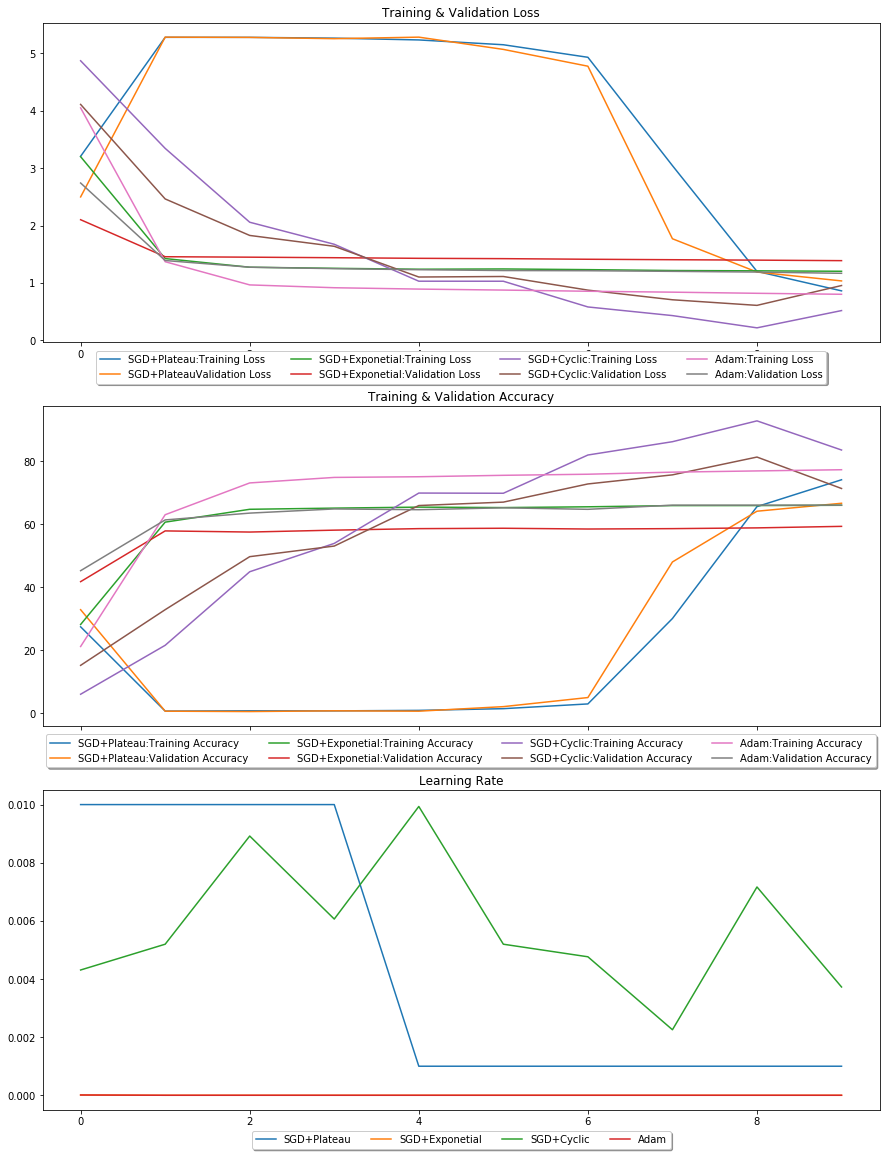

In [19]:
training_loss = np.zeros([4,10])
training_acc = np.zeros([4,10])
val_loss  = np.zeros([4,10])
val_acc  = np.zeros([4,10])
lr  = np.zeros([4,10])


#torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01)
for i in range(4):
    model_ft = init_model('resnet18', num_classes, feature_extract=False, use_pretrained=True)
    if i == 0:
        loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
    elif i == 1:
        loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        lrscheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)
    elif i == 2:
        loss = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=2, step_size_down=2)
    else:
        loss = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
        lrscheduler = optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

      
    # Training
    model, training_loss[i], training_acc[i], val_loss[i], val_acc[i], lr[i] = train_model(model_ft, loss, optimizer, lrscheduler, n_epochs=10, export_onnx = False)

f, axarr = plt.subplots(3,1,figsize=(15,20))
axarr[0].plot(training_loss[3], label='SGD+Plateau:Training Loss')
axarr[0].plot(val_loss[3], label='SGD+PlateauValidation Loss')
axarr[0].plot(training_loss[1], label='SGD+Exponetial:Training Loss')
axarr[0].plot(val_loss[1], label='SGD+Exponetial:Validation Loss')
axarr[0].plot(training_loss[2], label='SGD+Cyclic:Training Loss')
axarr[0].plot(val_loss[2], label='SGD+Cyclic:Validation Loss')
axarr[0].plot(training_loss[0], label='Adam:Training Loss')
axarr[0].plot(val_loss[0], label='Adam:Validation Loss')  
axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=4)
axarr[0].set_title("Training & Validation Loss")
axarr[1].plot(training_acc[3], label='SGD+Plateau:Training Accuracy')
axarr[1].plot(val_acc[3], label='SGD+Plateau:Validation Accuracy')
axarr[1].plot(training_acc[1], label='SGD+Exponetial:Training Accuracy')
axarr[1].plot(val_acc[1], label='SGD+Exponetial:Validation Accuracy')
axarr[1].plot(training_acc[2], label='SGD+Cyclic:Training Accuracy')
axarr[1].plot(val_acc[2], label='SGD+Cyclic:Validation Accuracy')
axarr[1].plot(training_acc[0], label='Adam:Training Accuracy')
axarr[1].plot(val_acc[0], label='Adam:Validation Accuracy')  
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),fancybox=True, shadow=True, ncol=4)
axarr[1].set_title("Training & Validation Accuracy")
axarr[2].plot(lr[3], label='SGD+Plateau')
axarr[2].plot(lr[1], label='SGD+Exponetial')
axarr[2].plot(lr[2], label='SGD+Cyclic')
axarr[2].plot(lr[0], label='Adam') 
axarr[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=4)
axarr[2].set_title("Learning Rate")


f.savefig(img_dir+'learning_curve_'+model_ft.name+model_ft.use_pretrained+'_compare_optimizer.png', bbox_inches='tight')

In [22]:
lr[2] = ()

array([0.00749038, 0.00857212, 0.00586779, 0.00694952, 0.00547837])

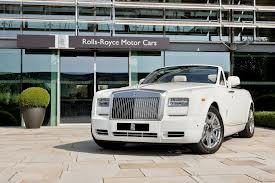

label: Rolls-Royce Phantom Sedan 2012 
predicted: Rolls-Royce Phantom Sedan 2012


In [90]:
model_ft = init_model('resnet50', num_classes, feature_extract=False, use_pretrained=True)
model_ft.load_state_dict(torch.load(model_dir+'resnet_ensemble_4_pretrained.pt'))
model_ft.eval()

# transforms for the input image
loader = test_tfms
#image = Image.open(dataset_dir+"/Rolls-Royce Phantom Sedan 2012/07721.jpg")
#image = Image.open(dataset_dir+"/Rolls-Royce Phantom Drophead Coupe Convertible 2012/00093.jpg")
image = Image.open(dataset_dir+"/Rolls-Royce Phantom Sedan 2012/03248.jpg")
#image = Image.open(dataset_dir+"/Bentley Arnage Sedan 2009/02676.jpg")
display(image)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)
print("label: Rolls-Royce Phantom Sedan 2012 \npredicted:",classes[predicted.item()])